<strong><center><h1>Analyzing Stock Options with Machine Learning</h1></center></strong>

## **1. Introduction**

#### For many years, traders and merchants developed and practiced techniques involving the prediction of prices for goods. These techniques were then used for predicting stock prices (Hayes, 2019). Many of these techniques are still used today. Recently, more traders have been relying on the use of algorithms for automated trading and price prediction. An advantage many have found with using algorithms is that it strips trading of personal attachment (i.e. emotions). This project in focuses more on the prediction of stock options.

#### Stock options are contracts that give an individual the right to **buy** or **sell** a stock at a specific price by a specific date (Palmer, 2019). They can either be a buy or a sell contract known as a **call** and a **put**, respectively. These options allow an individual to buy or sell their option if the price of a stock reaches a certain price point. This project involves the use of historical stock option data to predict a call or a put for future option investments.

#### The goal of this project is to make observations of multiple models involved with predicting stock options and compare them.

## **2. Data**

### **A. Importing Libraries and Data**

In [1]:
from copy import deepcopy as copy
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from numpy import shape
from math import log, sqrt, exp, pi
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import animation

import tensorflow as tf
from tensorflow import keras 
from copy import deepcopy as copy
import IPython.display as ipd 
import importlib
import partitionlib as ptl

#### There are multiple sources of data located in the **Sample_L2_2018** directory. The name of the dataset correlates to when the data was collected (i.e. **20180102** = **01/02/2018**).


#### For the initial experiments, we will use the data for the first month. 

In [2]:
options = pd.concat(map(pd.read_csv, glob.glob("Sample_L2_2018/L2_options_2018*.csv")))
options

,UnderlyingSymbol,UnderlyingPrice,Exchange,OptionSymbol,OptionExt,Type,Expiration,DataDate,Strike,Last,Bid,Ask,Volume,OpenInterest,IV,Delta,Gamma,Theta,Vega,AKA
0,NFLX,201.07,*,NFLX180105C00140000,NaN,call,01/05/2018,01/02/2018,140.0,0.00,60.65,61.70,0,0,0.4771,1.0000,0.0000,-2.2535,0.0000,NFLX180105C00140000
1,NFLX,201.07,*,NFLX180105P00140000,NaN,put,01/05/2018,01/02/2018,140.0,0.01,0.00,0.03,33,0,0.5949,0.0000,0.0000,0.0000,0.0000,NFLX180105P00140000
2,NFLX,201.07,*,NFLX180105C00145000,NaN,call,01/05/2018,01/02/2018,145.0,0.00,55.55,56.70,0,0,0.4771,1.0000,0.0000,-2.3340,0.0000,NFLX180105C00145000
3,NFLX,201.07,*,NFLX180105P00145000,NaN,put,01/05/2018,01/02/2018,145.0,0.00,0.00,0.03,0,0,0.5949,0.0000,0.0000,0.0000,0.0000,NFLX180105P00145000
4,NFLX,201.07,*,NFLX180105C00150000,NaN,call,01/05/2018,01/02/2018,150.0,37.00,50.85,51.70,0,9,0.4771,1.0000,0.0000,-2.4145,0.0000,NFLX180105C00150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,UVXY,81.73,*,UVXY210115P00170000,NaN,put,01/15/2021,12/31/2018,170.0,113.74,112.00,116.00,2,12,1.0488,-0.3769,0.0030,-8.4212,42.4784,UVXY210115P00170000
2526,UVXY,81.73,*,UVXY210115C00175000,NaN,call,01/15/2021,12/31/2018,175.0,22.00,19.70,21.50,0,986,0.8693,0.4698,0.0037,-8.6118,43.8514,UVXY210115C00175000
2527,UVXY,81.73,*,UVXY210115P00175000,NaN,put,01/15/2021,12/31/2018,175.0,118.40,116.00,120.40,18,20,1.0473,-0.3846,0.0030,-8.3665,42.6961,UVXY210115P00175000
2528,UVXY,81.73,*,UVXY210115C00180000,NaN,call,01/15/2021,12/31/2018,180.0,20.15,19.10,21.05,368,174,0.8687,0.4610,0.0037,-8.6191,43.8372,UVXY210115C00180000


#### In order to help determine relevant features, we will call the <code>unique()</code> method provided by the pandas library in order to check unique values in a feature.

#### In this case, the *OptionExt* feature only contains a value of *NaN*. Therefore, we can exclude it in our data.

In [3]:
options['OptionExt'].unique()

array([nan])

In [4]:
options['Exchange'].unique()

array(['*'], dtype=object)

In [5]:
options['Expiration'].unique()

array(['01/05/2018', '01/12/2018', '01/19/2018', '01/26/2018',
       '02/02/2018', '02/09/2018', '02/16/2018', '03/16/2018',
       '04/20/2018', '06/15/2018', '01/18/2019', '06/21/2019',
       '01/17/2020', '02/23/2018', '03/02/2018', '09/21/2018',
       '03/09/2018', '03/23/2018', '07/20/2018', '03/29/2018',
       '05/18/2018', '10/19/2018', '04/06/2018', '04/13/2018',
       '04/27/2018', '05/04/2018', '05/11/2018', '05/25/2018',
       '06/01/2018', '12/21/2018', '06/08/2018', '06/22/2018',
       '06/29/2018', '08/17/2018', '07/06/2018', '07/13/2018',
       '07/27/2018', '08/03/2018', '08/10/2018', '09/28/2018',
       '12/31/2018', '03/29/2019', '06/28/2019', '08/24/2018',
       '08/31/2018', '03/15/2019', '09/07/2018', '11/16/2018',
       '02/15/2019', '09/14/2018', '10/05/2018', '10/12/2018',
       '10/26/2018', '11/02/2018', '01/15/2021', '05/17/2019',
       '11/09/2018', '10/03/2018', '10/10/2018', '10/17/2018',
       '10/24/2018', '10/31/2018', '11/21/2018', '12/19

In [6]:
options['OpenInterest'].unique()

array([   0,    9,   52, ..., 4084, 5813, 5822], dtype=int64)

#### The *Type* feature in our data contains strings to classify the data. We will convert the data into integers by using the <code>astype()</code> method and passing *int* as an argument.

In [7]:
options['Type'] = (options['Type'] != 'call').astype(int)

#### Now we can represent the *Type* feature as integers and drop the irrelevant features from our data.

In [8]:
X = options.drop(['DataDate', 'OptionExt', 'AKA', 'OptionSymbol', 'Exchange'], axis=1).copy()

In [9]:
X

,UnderlyingSymbol,UnderlyingPrice,Type,Expiration,Strike,Last,Bid,Ask,Volume,OpenInterest,IV,Delta,Gamma,Theta,Vega
0,NFLX,201.07,0,01/05/2018,140.0,0.00,60.65,61.70,0,0,0.4771,1.0000,0.0000,-2.2535,0.0000
1,NFLX,201.07,1,01/05/2018,140.0,0.01,0.00,0.03,33,0,0.5949,0.0000,0.0000,0.0000,0.0000
2,NFLX,201.07,0,01/05/2018,145.0,0.00,55.55,56.70,0,0,0.4771,1.0000,0.0000,-2.3340,0.0000
3,NFLX,201.07,1,01/05/2018,145.0,0.00,0.00,0.03,0,0,0.5949,0.0000,0.0000,0.0000,0.0000
4,NFLX,201.07,0,01/05/2018,150.0,37.00,50.85,51.70,0,9,0.4771,1.0000,0.0000,-2.4145,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,UVXY,81.73,1,01/15/2021,170.0,113.74,112.00,116.00,2,12,1.0488,-0.3769,0.0030,-8.4212,42.4784
2526,UVXY,81.73,0,01/15/2021,175.0,22.00,19.70,21.50,0,986,0.8693,0.4698,0.0037,-8.6118,43.8514
2527,UVXY,81.73,1,01/15/2021,175.0,118.40,116.00,120.40,18,20,1.0473,-0.3846,0.0030,-8.3665,42.6961
2528,UVXY,81.73,0,01/15/2021,180.0,20.15,19.10,21.05,368,174,0.8687,0.4610,0.0037,-8.6191,43.8372


### **B. Explanation of Features**

&emsp; *provided by Historical Option Data: https://www.historicaloptiondata.com/content/historical-options-data-file-structures-0*
* #### **Expiration:** This is the time it takes until the stock option expires. After the contract expires, the buyer must commit to their option (call or put).
* #### **Strike:** The price at which an option holder can buy or sell.
* #### **Last:** The last traded price of the option.
* #### **Bid:** The price an option buyer is willing to pay for the contract.
* #### **Ask:** The price an option seller is willing to sell for the contract.
* #### **Volume:** The number of contracts traded.
* #### **OpenInterest:** Always a day behind - the number of options that are held by traders and investors in active positions.
* #### **Implied Volatility(IV):** A measure of the estimate of how much the price could change. It relates to how likely the traders believe the option can make a change.
* #### **Delta:** A measure of how much the option price would change in relation to the underlying stock price. Delta = .50 -> option changes 50 cents for every 1 dollar the stock moves.
* #### **Gamma:** A measure of how fast the Delta will change when the stock price changes. A high number means this is a very explosive option and can gain or lose value quickly.
* #### **Theta:** A measure of how fast the option is losing value per day due to time decay. As the expiration day arrives, the theta increases.
* #### **Vega:** A meaasure of how sensitive the option price is to a change in the implied volatility. Options that have a long time until expiration are more sensitive to change in IV.

### **C. Preprocessing the Data**

#### Here, we converted the date into the days until expiration with the <code>to_datetime()</code> method.

In [10]:
X['Expiration'] = pd.to_datetime(X['Expiration']).sub(pd.Timestamp('01/02/2018')).dt.days
X

,UnderlyingSymbol,UnderlyingPrice,Type,Expiration,Strike,Last,Bid,Ask,Volume,OpenInterest,IV,Delta,Gamma,Theta,Vega
0,NFLX,201.07,0,3,140.0,0.00,60.65,61.70,0,0,0.4771,1.0000,0.0000,-2.2535,0.0000
1,NFLX,201.07,1,3,140.0,0.01,0.00,0.03,33,0,0.5949,0.0000,0.0000,0.0000,0.0000
2,NFLX,201.07,0,3,145.0,0.00,55.55,56.70,0,0,0.4771,1.0000,0.0000,-2.3340,0.0000
3,NFLX,201.07,1,3,145.0,0.00,0.00,0.03,0,0,0.5949,0.0000,0.0000,0.0000,0.0000
4,NFLX,201.07,0,3,150.0,37.00,50.85,51.70,0,9,0.4771,1.0000,0.0000,-2.4145,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,UVXY,81.73,1,1109,170.0,113.74,112.00,116.00,2,12,1.0488,-0.3769,0.0030,-8.4212,42.4784
2526,UVXY,81.73,0,1109,175.0,22.00,19.70,21.50,0,986,0.8693,0.4698,0.0037,-8.6118,43.8514
2527,UVXY,81.73,1,1109,175.0,118.40,116.00,120.40,18,20,1.0473,-0.3846,0.0030,-8.3665,42.6961
2528,UVXY,81.73,0,1109,180.0,20.15,19.10,21.05,368,174,0.8687,0.4610,0.0037,-8.6191,43.8372


#### In order to stay consistent with the other features, we must convert the time until expiration into units of years.

In [11]:
X['Expiration'] = X['Expiration'].apply(lambda x: x / 365)
X

,UnderlyingSymbol,UnderlyingPrice,Type,Expiration,Strike,Last,Bid,Ask,Volume,OpenInterest,IV,Delta,Gamma,Theta,Vega
0,NFLX,201.07,0,0.008219,140.0,0.00,60.65,61.70,0,0,0.4771,1.0000,0.0000,-2.2535,0.0000
1,NFLX,201.07,1,0.008219,140.0,0.01,0.00,0.03,33,0,0.5949,0.0000,0.0000,0.0000,0.0000
2,NFLX,201.07,0,0.008219,145.0,0.00,55.55,56.70,0,0,0.4771,1.0000,0.0000,-2.3340,0.0000
3,NFLX,201.07,1,0.008219,145.0,0.00,0.00,0.03,0,0,0.5949,0.0000,0.0000,0.0000,0.0000
4,NFLX,201.07,0,0.008219,150.0,37.00,50.85,51.70,0,9,0.4771,1.0000,0.0000,-2.4145,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,UVXY,81.73,1,3.038356,170.0,113.74,112.00,116.00,2,12,1.0488,-0.3769,0.0030,-8.4212,42.4784
2526,UVXY,81.73,0,3.038356,175.0,22.00,19.70,21.50,0,986,0.8693,0.4698,0.0037,-8.6118,43.8514
2527,UVXY,81.73,1,3.038356,175.0,118.40,116.00,120.40,18,20,1.0473,-0.3846,0.0030,-8.3665,42.6961
2528,UVXY,81.73,0,3.038356,180.0,20.15,19.10,21.05,368,174,0.8687,0.4610,0.0037,-8.6191,43.8372


## **3. The Black-Scholes Model**

#### The Black-Scholes Model, or Black-Scholes-Merton (BSM) Model, is one of the most well-known models used in finance. The model implies that the most relevant features of pricing a stock option depends on:
#### &emsp;&emsp;$S$: Stock Price
#### &emsp;&emsp;$X$: Exercise Price
#### &emsp;&emsp;$r$: Risk-Free Interest Rate
#### &emsp;&emsp;$T$: Time until Expiration
#### &emsp;&emsp;$\theta$: Standard Deviation of *log* returns (volatility)<br><br>

<center><h4>The BSM involves a mathematical formula that determines a fair price for stock options.</h4></center><br>

<center><h4>$C_0$ $=$ $S_0N(d_1) - Xe^{(-rt)}N(d_2)$</h4></center><br>

<center><h4>where</h4></center><br>

<center><h4>$d_1 = \frac{ln\frac{S_t}{X}+(r+\frac{\theta^2}{2}T}{\theta\sqrt{T}}$, $d_2 = \frac{ln\frac{S_t}{X}+(r-\frac{\theta^2}{2}T}{\theta\sqrt{T}}$</h4></center><br>

<center><h4>$N(X)$ gives us the probability where our random variable will be less than or equal to $X$.</h4></center><br>

<center><h4>$0 < N(X) < 1$</h4></center><br>

<center><h4>The price of the stock, $S_0$, is weighted by the probability $N(X)$:</h4></center><br>

<center><h4>$S_0N(d_1)$</h4></center><br>

<center><h4>The amount you would pay is determined by multiplying $X$ and $e$ raised to $(-rt)$, then weighted by $N(X)$:</h4></center><br>

<center><h4>$Xe^{(-rt)}N(d_2)$</h4></center>

### **A. Implementation**

#### This implementation of the BSM was provided by QuantConnect.

In [12]:
class BsmModel:
    
    def __init__(self, option_type, price, strike, interest_rate, expiry, volatility, dividend_yield=0):
        self.type = option_type # 0 for call, 1 for put
        self.s = price # underlying asset price
        self.k = strike # strike price of option
        self.r = interest_rate # risk-free interest rate
        self.T = expiry # time till expiration in years
        self.sigma = volatility # standard deviation of log returns
        self.q = dividend_yield # dividend continuous rate
        
    def n(self, d):
        # cumulative probabilty distribution function of standard normal distribution; N(X)
        return norm.cdf(d)
    
    def dn(self, d):
        # first order derivative of n(d)
        return norm.pdf(d)
    
    def d1(self):
        d1 = (log(self.s / self.k) + (self.r - self.q + self.sigma ** 2 * 0.5) * self.T) / (self.sigma * sqrt(self.T))
        return d1
    
    def d2(self):
        d2 = (log(self.s / self.k) + (self.r - self.q - self.sigma ** 2 * 0.5) * self.T) / (self.sigma * sqrt(self.T))
        return d2
    
    def bsm_price(self):
        d1 = self.d1()
        d2 = d1 - self.sigma * sqrt(self.T)
        if self.type == 0:
            price = exp(-self.r*self.T) * (self.s * exp((self.r - self.q)*self.T) * self.n(d1) - self.k * self.n(d2))
            return price
        elif self.type == 1:
            price = exp(-self.r*self.T) * (self.k * self.n(-d2) - (self.s * exp((self.r - self.q)*self.T) * self.n(-d1)))
            return price
        else:
            print("option either 0 (call) or 1 (put)")

In [13]:
bsmX = X[['Type', 'UnderlyingPrice', 'Strike', 'Expiration', 'IV']]
bsmX

,Type,UnderlyingPrice,Strike,Expiration,IV
0,0,201.07,140.0,0.008219,0.4771
1,1,201.07,140.0,0.008219,0.5949
2,0,201.07,145.0,0.008219,0.4771
3,1,201.07,145.0,0.008219,0.5949
4,0,201.07,150.0,0.008219,0.4771
...,...,...,...,...,...
2525,1,81.73,170.0,3.038356,1.0488
2526,0,81.73,175.0,3.038356,0.8693
2527,1,81.73,175.0,3.038356,1.0473
2528,0,81.73,180.0,3.038356,0.8687


In [14]:
bsmX['BSM'] = bsmX.apply(lambda x: BsmModel(x["Type"], x["UnderlyingPrice"], x["Strike"], 0.1, x["Expiration"], x["IV"]).bsm_price(), axis=1)

C:\Users\Trini\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
bsmX

,Type,UnderlyingPrice,Strike,Expiration,IV,BSM
0,0,201.07,140.0,0.008219,0.4771,6.118502e+01
1,1,201.07,140.0,0.008219,0.5949,1.114234e-11
2,0,201.07,145.0,0.008219,0.4771,5.618913e+01
3,1,201.07,145.0,0.008219,0.5949,8.838918e-10
4,0,201.07,150.0,0.008219,0.4771,5.119324e+01
...,...,...,...,...,...,...
2525,1,81.73,170.0,3.038356,1.0488,8.942834e+01
2526,0,81.73,175.0,3.038356,0.8693,3.654093e+01
2527,1,81.73,175.0,3.038356,1.0473,9.259320e+01
2528,0,81.73,180.0,3.038356,0.8687,3.598391e+01


## **4. The Greek Letters**

#### In our dataset, there are 4 greek letters that were provided: *Delta, Gamma, Theta*, and *Vega*. Each greek letter is a parameter that is used to measure different dimensions in options.
* #### Delta: The measure of how much the option price would change in relation to the underlying stock price.
* #### Gamma: The measure of how fast the Delta will change when the stock prices change.
* #### Theta: The measure of how fast the option is losing value per day due to time decay.
* #### Vega: The measure of how sensitive the option price is to a change in the implied volatility.
* #### Rho: The measure of how sensitive the option price is to a change in interest rate.

#### These values are typically calculated on a daily basis. Once the values for these letters have been determined, traders would apply them to the BSM model to asses option prices.

### **A. Implementation**

#### Since our dataset has already provided the values for the greeks (*Delta, Gamma, Theta, and Vega*), we will use them to assess the BSM model created in the previous section.

In [16]:
delta = X[['Delta']].to_numpy()
gamma = X[['Gamma']].to_numpy()
theta = X[['Theta']].to_numpy()
vega = X[['Vega']].to_numpy()

In [17]:
price = bsmX.iloc[:, 1].to_numpy()
time = bsmX.iloc[:, 3].to_numpy()

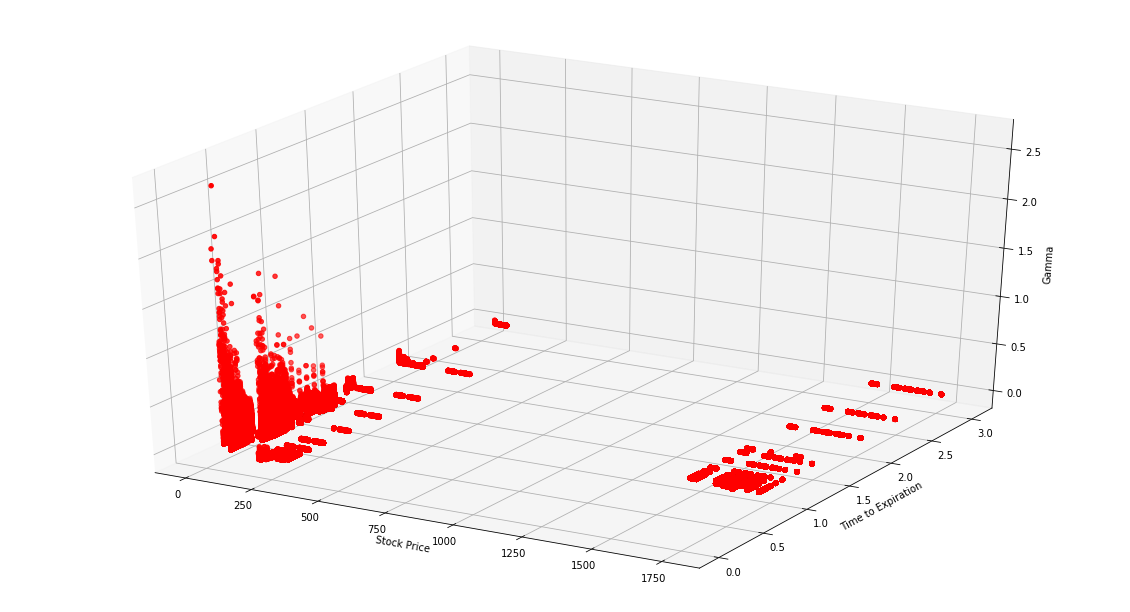

In [18]:
fig = plt.figure(figsize=(20,11))
ax = plt.axes(projection='3d')
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiration')
ax.set_zlabel('Gamma')
ax.scatter(price, time, gamma, color='r')
plt.show()

## Tensorflow

In [19]:
nEpochs = 200
bSize = 1000
def partition_data(X, T):
    """Partition data into train and test splits."""
    data, targets = ptl.partition(copy(X.values), copy(T.values))
    Xtrain, Xtest = data
    Ttrain, Ttest = targets
    
    return Xtrain, Xtest, Ttrain, Ttest
def standardize(X, mean, std):
    return (X-mean) / std
def plot_fit(Y, T, title=None):
    """ Plot the passed predictions and targets while also computing
        and printing the RMSE.
    """
    plt.plot(T, label="target")
    plt.plot(Y, linewidth=3, label="prediction")
    plt.legend()
    plt.ylabel("SO2")
    plt.xlabel("Samples")
    plt.title(title)
    # RMSE
    rmse = np.sqrt(np.mean((Y - T)**2))
    print("RMSE: {}".format(rmse))

In [20]:
Xtrain, Xtest, Ttrain, Ttest = partition_data(X, T)
N, D = X.shape
Ntrain, Ntest = Xtrain.shape[0], Xtest.shape[0]
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))
print("Number of total samples: {}".format(N))
print("Number of total features: {}".format(D))
print("Number of training samples: {}".format(Ntrain))
print("Number of testing samples: {}".format(Ntest))

#Xtrain = Xtrain.reshape([Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], -1])
#Xtest = Xtest.reshape([Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], -1])

pd.DataFrame(Xtrain).describe()

NameError: name 'T' is not defined